# Locality Sensitive Hashing

##Importing necessary packages:-

In [1]:
import numpy as np
import graphlab
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
import time
from copy import copy
import matplotlib.pyplot as plt
%matplotlib inline

def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

##Loading in the Wikipedia dataset:-

In [3]:
wiki = graphlab.SFrame('people_wiki.gl/')

##Assigning a uniqueID to each document:-

In [4]:
wiki = wiki.add_row_number()
wiki

id,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
1,<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
2,<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
3,<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
4,<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...
5,<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...
6,<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...
7,<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...
8,<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
9,<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...


##Extracting TF-IDF matrix:-

In [5]:
wiki['tf_idf'] = graphlab.text_analytics.tf_idf(wiki['text'])
wiki

id,URI,name,text,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...,"{'since':1.455376717308041, ..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...,"{'precise':6.44320060695519, ..."
2,<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...,"{'just':2.7007299687108643, ..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...,"{'all':1.6431112434912472, ..."
4,<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...,"{'legendary':4.280856294365192, ..."
5,<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...,"{'now': 1.96695239252401,'currently': ..."
6,<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...,"{'exclusive':10.455187230695827, ..."
7,<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...,"{'taxi':6.0520214560945025, ..."
8,<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...,"{'houston':3.935505942157149, ..."
9,<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...,"{'phenomenon':5.750053426395245, ..."


##Converting the TF-IDF column (in dictionary format) into the SciPy sparse matrix format:-

In [6]:
def sframe_to_scipy(column):

    # Creating triples of (row_id, feature_id, count).
    x = graphlab.SFrame({'X1':column})
    
    # Adding a row number.
    x = x.add_row_number()
    # Stack will transform x to have a row for each unique (row, key) pair.
    x = x.stack('X1', ['feature', 'value'])

    # Mapping words into integers using a OneHotEncoder feature transformation.
    f = graphlab.feature_engineering.OneHotEncoder(features=['feature'])

    f.fit(x)

    # The transform method will add a new column that is the transformed version
    # of the 'word' column.
    x = f.transform(x)

    # The feature mapping.
    mapping = f['feature_encoding']

    # The actual word id.
    x['feature_id'] = x['encoded_features'].dict_keys().apply(lambda x: x[0])

    # Creating numpy arrays that contain the data for the sparse matrix.
    i = np.array(x['id'])
    j = np.array(x['feature_id'])
    v = np.array(x['value'])
    width = x['id'].max() + 1
    height = x['feature_id'].max() + 1

    # Creating a sparse matrix.
    mat = csr_matrix((v, (i, j)), shape=(width, height))

    return mat, mapping

In [7]:
start=time.time()
corpus, mapping = sframe_to_scipy(wiki['tf_idf'])
end=time.time()
print end-start

113.866999865


##Training an LSH model:-

##Building a popular variant of LSH known as random binary projection, which approximates cosine distance:-

In [9]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

In [11]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partitioning data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encoding bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Updating `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] =[]
        # Fetching the list of document ids associated with the bin and add the document id to the end.
        table[bin_index].append(data_index) 

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

##Inspecting bins:-

In [13]:
wiki[wiki['name'] == 'Barack Obama']

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'operations':3.811771079388818, ..."


##Document `id` of Barack Obama's article and location of bin which contains Barack Obama's article:-

In [14]:
doc = corpus[35817, :]  # first document
index_bits = (doc.dot(model['random_vectors']) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print index_bits.dot(powers_of_two)
print np.array(index_bits)

[50194]
[[ True  True False False False  True False False False False False  True
  False False  True False]]


##Documents in the same bin as Barack Obama:-

In [15]:
model['table'][model['bin_indices'][35817]]

[21426, 35817, 39426, 50261, 53937]

##Thus other documents that belong to the same bin are:-

In [16]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # displaying documents other than Obama

docs = wiki.filter_by(values=doc_ids, column_name='id') # filtering by id column
docs

id,URI,name,text,tf_idf
21426,<http://dbpedia.org/resource/Mark_Boulware> ...,Mark Boulware,mark boulware born 1948is an american diplomat ...,"{'ambassador':15.90834582606623, ..."
39426,<http://dbpedia.org/resource/John_Wells_(polit ...,John Wells (politician),sir john julius wellsborn 30 march 1925 is a ...,"{'when':1.3806055739282235, ..."
50261,<http://dbpedia.org/resource/Francis_Longstaff> ...,Francis Longstaff,francis a longstaff bornaugust 3 1956 is an ...,"{'all':1.6431112434912472, ..."
53937,<http://dbpedia.org/resource/Madurai_T._Sriniv ...,Madurai T. Srinivasan,maduraitsrinivasan is awellknown figure in the ...,"{'alarmelu':21.972990778450388, ..."


In [18]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

##Querying the LSH model:-

logic for searching nearby neighbors is:
```
1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.
...
```

To obtain candidate bins that differ from the query bin by some number of bits, we use `itertools.combinations`, which produces all possible subsets of a given list.
Search radius r will determine the number of different bits between the two vectors.

In [19]:
from itertools import combinations

In [20]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allows the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flipping the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = not(alternate_bits[i])
        
        # Converting the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetching the list of documents belonging to the bin indexed by the new bit vector.
        # Then adding those documents to candidate_set
        if nearby_bin in table:
             candidate_set.update(table[nearby_bin])
            
    return candidate_set

##Function to collect all candidates and compute their true distance to the query:-

In [23]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Computing bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Searching nearby bins and collect candidates
    candidate_set = set()
    for search_radius in xrange(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sorting candidates by their true distances from the query
    nearest_neighbors = graphlab.SFrame({'id':candidate_set})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True), len(candidate_set)

So for Obama article:-

In [24]:
query(corpus[35817,:], model, k=10, max_search_radius=3)

(Columns:
 	id	int
 	distance	float
 
 Rows: 10
 
 Data:
 +-------+--------------------+
 |   id  |      distance      |
 +-------+--------------------+
 | 35817 | -6.66133814775e-16 |
 | 24478 |   0.703138676734   |
 | 56008 |   0.856848127628   |
 | 37199 |   0.874668698194   |
 | 40353 |   0.890034225981   |
 |  9267 |   0.898377208819   |
 | 55909 |   0.899340396322   |
 |  9165 |   0.900921029925   |
 | 57958 |   0.903003263483   |
 | 49872 |   0.909532800353   |
 +-------+--------------------+
 [10 rows x 2 columns], 727)

##Joining this table with the Wikipedia table:-

In [25]:
query(corpus[35817,:], model, k=10, max_search_radius=3)[0].join(wiki[['id', 'name']], on='id').sort('distance')

id,distance,name
35817,-6.66133814775e-16,Barack Obama
24478,0.703138676734,Joe Biden
56008,0.856848127628,Nathan Cullen
37199,0.874668698194,Barry Sullivan (lawyer)
40353,0.890034225981,Neil MacBride
9267,0.898377208819,Vikramaditya Khanna
55909,0.899340396322,Herman Cain
9165,0.900921029925,Raymond F. Clevenger
57958,0.903003263483,Michael J. Malbin
49872,0.909532800353,Lowell Barron


##Running LSH multiple times, each with different radii for nearby bin search:-

In [26]:
wiki[wiki['name']=='Barack Obama']

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'operations':3.811771079388818, ..."


In [27]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in xrange(17):
    start=time.time()
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start
    
    print 'Radius:', max_search_radius
    print result.join(wiki[['id', 'name']], on='id').sort('distance')
    
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
+-------+--------------------+-------------------------+
|   id  |      distance      |           name          |
+-------+--------------------+-------------------------+
| 35817 | -6.66133814775e-16 |       Barack Obama      |
| 21426 |   0.950866757525   |      Mark Boulware      |
| 39426 |   0.97596600411    | John Wells (politician) |
| 50261 |   0.978256163041   |    Francis Longstaff    |
| 53937 |   0.993092148424   |  Madurai T. Srinivasan  |
+-------+--------------------+-------------------------+
[5 rows x 3 columns]

Radius: 1
+-------+--------------------+-------------------------------+
|   id  |      distance      |              name             |
+-------+--------------------+-------------------------------+
| 35817 | -6.66133814775e-16 |          Barack Obama         |
| 41631 |   0.947459482005   |          Binayak Sen          |
| 21426 |   0.950866757525   |         Mark Boulware         |
| 33243 |   0.951765770113   |        Janice Lachance        |
| 33

##Plotting it gives us:-

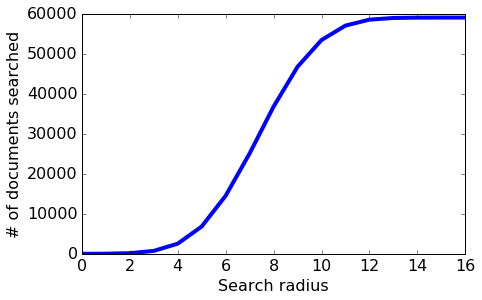

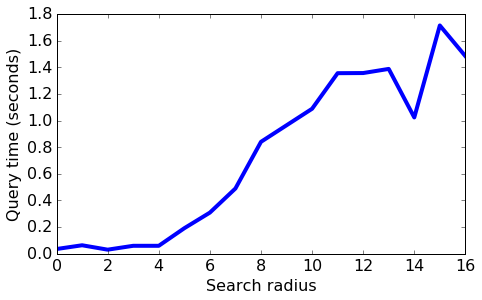

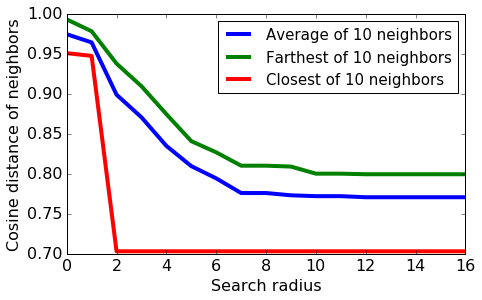

In [28]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()